# Image example: more=better

Generating multiple images and picking the best. TODO link post.

In [25]:
import torch, requests, os
import numpy as np
from transformers import AutoProcessor, AutoModel
from PIL import Image
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from transformers import CLIPProcessor, CLIPModel
from tqdm.auto import tqdm

## Generating Images

You could use a local generation pipeline, an API like OpenAI's Dalle-3, or something like Replicate. Since Replicate makes it easy to swap out lots of different models let's use that for now:

In [18]:
import replicate
client = replicate.Client(api_token=your_api_token)  
def generate(prompt):
    output = client.run(
        "playgroundai/playground-v2.5-1024px-aesthetic:a45f82a1382bed5c7aeb861dac7c7d191b0fdf74d8d57c4a0e6ed7d4d0bf7d24",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": prompt,
            "scheduler": "DPMSolver++",
            "num_outputs": 1,
            "guidance_scale": 3,
            "apply_watermark": True,
            "negative_prompt": "ugly, deformed, noisy, blurry, distorted",
            "prompt_strength": 0.8,
            "num_inference_steps": 25
        }
    )
    return Image.open(requests.get(output[0], stream=True).raw)


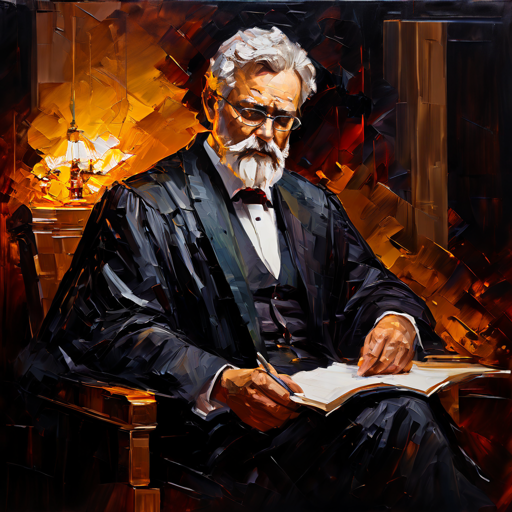

In [20]:
image = generate("Painting of a judge, palette knife, detailed, 8k")
image.resize((512, 512)) # Smaller preview

## Scoring Functions

These both take an image and return a score, which we can later use to rank the images.

CLIP measures similarity between the text and the image - higher is better

PickScore is trained to score (image, prompt) pairs based on user ratings of generated images. Again, higher is better. It tends to penalize things like extra limbs and artefacts.

In [2]:
# Clip score
class CLIPScorer:
    def __init__(self):
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    @torch.no_grad()
    def get_score(self, image, prompt):
        inputs = self.clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True)
        outputs = self.clip_model(**inputs)
        return outputs.logits_per_image[0].item()

In [3]:
# PickScore
class PICKScorer:
    def __init__(self):
        self.processor = AutoProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
        self.model = AutoModel.from_pretrained("yuvalkirstain/PickScore_v1").eval().to("cuda")
    
    def get_score(self, image, prompt):
        # preprocess
        image_inputs = self.processor(
            images=image,
            padding=True,
            truncation=True,
            max_length=77,
            return_tensors="pt",
        ).to("cuda")
        
        text_inputs = self.processor(
            text=prompt,
            padding=True,
            truncation=True,
            max_length=77,
            return_tensors="pt",
        ).to("cuda")
    
    
        with torch.no_grad():
            # embed
            image_embs = self.model.get_image_features(**image_inputs)
            image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
        
            text_embs = self.model.get_text_features(**text_inputs)
            text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)
        
            # score
            scores = self.model.logit_scale.exp() * (text_embs @ image_embs.T)[0]
           
        return scores.cpu().tolist()[0]

In [4]:
# Load the models
clip_scorer = CLIPScorer()
pick_scorer = PICKScorer()

/home/jonathan/miniconda3/envs/cuda11-7/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

In [21]:
# Run both scores
score1 = clip_scorer.get_score(image, "Painting of a judge, palette knife, detailed, 8k")
print("CLIP Score:", score1)
score2 = pick_scorer.get_score(image, "Painting of a judge, palette knife, detailed, 8k")
print("PickScore Score:", score2)

CLIP Score: 26.883800506591797
PickScore Score: 21.594776153564453


In [40]:
# If the prompt doesn't match the image, the score is worse:
score1 = clip_scorer.get_score(image, "A man on the moon")
print("CLIP Score:", score1)

CLIP Score: 19.299386978149414


In [41]:
pick_scorer.get_score(image, "A man on the moon")

19.2353515625

## Generating multiple and picking the best

In [35]:
# Generate some images
prompt = "An old man with a red bird perched on his shoulder, acrylic painting"
candidates = [generate(prompt) for _ in tqdm(range(10))]

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
# Score them all
clip_scores = [clip_scorer.get_score(image, prompt) for image in candidates]
pickscore_scores = [pick_scorer.get_score(image, prompt) for image in candidates]

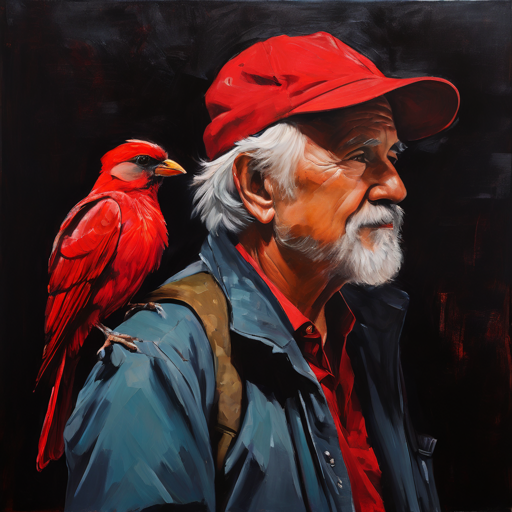

In [37]:
# Look at the best according to CLIP score
candidates[np.argmax(clip_scores)].resize((512, 512))

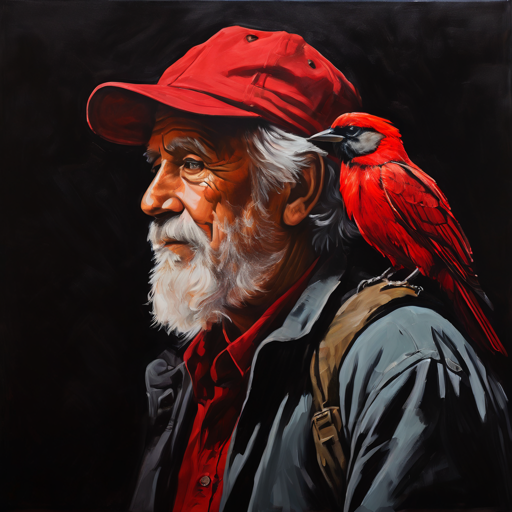

In [38]:
# Look at the best according to PickScore
candidates[np.argmax(pickscore_scores)].resize((512, 512))

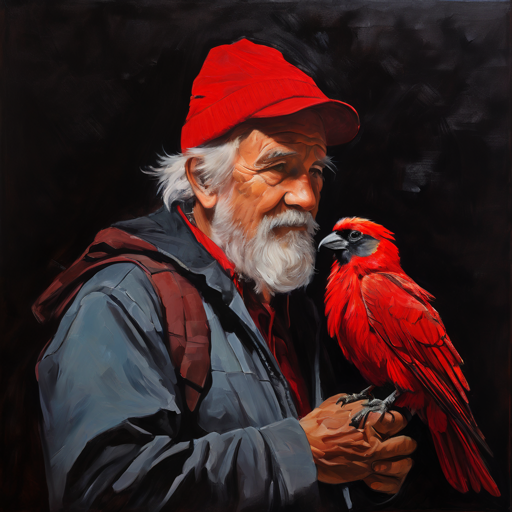

In [39]:
# And the worst:
candidates[np.argmin(pickscore_scores)].resize((512, 512))

These all look pretty good (it's a very aesthetic model) but the worst one doesn't have the bird on the shoulder, for example.